In [28]:
###############################################################
#
# Consumer-Resource model with production.
# Produces eigenvalue plots for symmetric and asymmetric P
# matrices.
# Each resource density = r
# Each species abundance = s
# Consumption matrix C = c*I  ### Completely specialized
#
################################################################

### RK Edits usually come after single '###'

In [4]:
import numpy as np
from numpy.random import normal, uniform
from numpy.linalg import eigvals
import math as mt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"     

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

%matplotlib inline

np.set_printoptions(precision=5)

np.random.seed(999)

In [5]:
## Asymmetric P matrix ##

def asymP(sig, n):

    return abs(normal(0, sig, (n, n))) ### "doubling-up" prob density by taking abs(normally distributed)???
                                        ### another distribution, but on the positive reals?
    

In [ ]:
## Symmetric P matrix ##

def symP(sig, n):
    
    P = np.empty((n, n))
    for i in range(n):
        for j in range(i + 1):
            P[j][i] = P[i][j] = abs(normal(0, sig))
    
    return P

In [22]:
### Vectorized Asymmetric P matrix
def asymPvec(sig, n, k=1):
    return abs(normal(0, sig, (k, n, n))) # again, a half-normal with mean=1

In [18]:
### Vectorized Symmetric P matrix
def symPvec(sig, n, k=1): # k, number of matrices to generate
    P = abs(normal(0,sig,(k,n,n)))
    P = np.maximum(P,np.transpose(P,(0,2,1))) #transpose each sub-P (only transpose last two dimensions)
    ### Is max an issue? Favors less probable p-values, I guess. Not QUITE normally dist'd 
                            ### after abs and this maximum. Effectively increases sigma?
    
    return P

In [19]:
def symPvec2(sig,n,k=1): ### This way does not use max, but slightly slower than symPvec
    P = abs(normal(0,sig,(k,n,n)))
    inds = np.tril_indices(n, k=-1)
    P[:,inds[1],inds[0]] = P[:,inds[0],inds[1]]
    
    return P

In [7]:
# p = symPvec(1,4,2)
# p.shape
# p == np.transpose(p,(0,2,1)) # Vectorized P-generator works

# p = symPvec2(1,4,2)
# p == np.transpose(p,(0,2,1)) # other one also works


In [8]:
### Original O'Dwyer method for determining/plotting stability
   # Fix a symmetric P, sP, and an asymmetric P, aP.
    # Pick uniform-random equilibria r and s, where unif bounds are chosen to guarantee positive mu and rho
        #mu and rho are only implicit in r and s, could be calculated from Eq 6? in Appendix
     # Evaluate Jacobian at r and s at each P, append eigenvalues
    

sev = np.array([])
aev = np.array([]) 

## Parameters ##

n   = 20      # number of species AND number of resrcs
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1       # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES

### SEE METHODS FOR mu AND rho

I = np.identity(n)

## Consumption Matrix ##

C = c * I

## Production matrices ##

sP = symP(sig, n)
aP = asymP(sig, n)
#sPvec = symPvec(sig, n)

rlb = n * sig * mt.sqrt(2 / mt.pi) / (c * eps) # mu and rho are hidden, i.e. some choice of those vector
                                                #produces this equilibrium


for k in range(5000): ### originally 5000
    ## Abundances ##
    
    r = uniform(rlb, 10 * rlb)           ### varying the densities at which Jacobian is evaluated
    s = uniform(rlb / 10**4, rlb / 1000)
    
    ## Linearized System ##
       ### Jacobian, L, eval'd at steady state
    #     [ LA | aLB]
    #aL = [---------]
    #     [ LC | LD ]
    LA  = -c * s * I
    
    sLB = sP - c * r * I ### the only partitions that differ between symmetric and asymmetric Production models
    aLB = aP - c * r * I

    LC = eps * c * s * I
    LD = np.zeros((n, n)) # DON'T REEVALUATE EVERY ITERATION

    sL  = np.vstack((np.hstack((LA, sLB)), np.hstack((LC, LD))))
    aL  = np.vstack((np.hstack((LA, aLB)), np.hstack((LC, LD))))
    
    ## Eigenvalues of Linearized System ##
    
    sev = np.append(sev, eigvals(sL))
    aev = np.append(aev, eigvals(aL))
    
# Why iterating with random populations rather than random P matrices at proper steady states?

In [9]:
rlb
# r

63.83076486422923

In [6]:
# Below, figuring the derivation of 'rlb'
# default PDF of normal, p_norm(x)
# sub for mu=0, sigma=1
# double due to half normal

$$ p_{norm}(x) = \frac{1}{{\sigma \sqrt {2\pi } }}e^{-\frac{1}{2} (\frac{x-\mu}{\sigma})^2} $$

$$ p_{norm}(x) = \frac{1}{{ \sqrt {2\pi } }}e^{-\frac{1}{2} x^2} $$
$$ p_{halfnorm}(x) = \frac{2}{{ \sqrt {2\pi } }}e^{-\frac{1}{2} x^2} $$
$$ p_{halfnorm}(x) = \sqrt{\frac{2}{\pi}}e^{-\frac{1}{2} x^2} $$

In [ ]:
# expectation of the above is np.sqrt(2/np.pi)

$$ rlb = \frac{n  \sigma  \sqrt{\frac{2}{\pi}} } {c  \epsilon} $$

$$ rlb = \frac{20  \sqrt{\frac{2}{\pi}} } {0.25}$$

$$ rlb = 80  \sqrt{\frac{2}{\pi}} $$

In [3]:
80*np.sqrt(2/np.pi)

63.83076486422923

In [10]:
# #print(eigvals(sL),'\n') #length 40
# # why all same real part in symmetric P

# # DOMINANT EIGENVALUE, domEig
# test = eigvals(aL)
# #print(test)
# reals = np.real(test)
# domEV_ind = np.argmax(np.abs(reals)) #lazy way, assume negative eigvals?
# domEV = test[domEV_ind]
# print(domEV)

# print(len(sev))
# print(len(aev))

# symP(1,5)

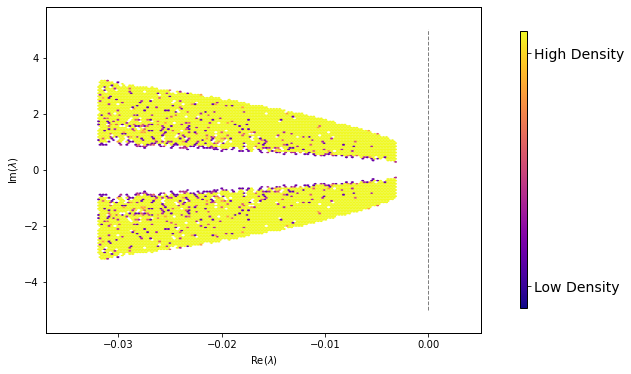

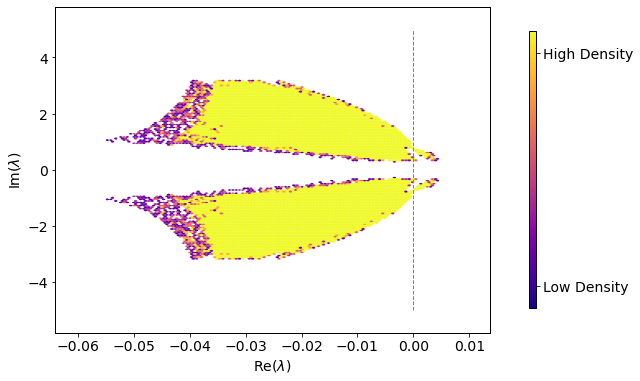

In [10]:
## Plot eigenvalues of linearized system ##

for i, q in enumerate([sev, aev]): # i index, q current value

    x = q.real
    y = q.imag

    plt.rcParams["axes.edgecolor"] = "black" 
    plt.rcParams["axes.linewidth"] = 1 
    
    fig, ax = plt.subplots(figsize = (10, 6))

    #cmap = plt.cm.viridis_r  ### old, gets an error
    cmap = mpl.cm.get_cmap("plasma").copy()
    cmap.set_under(color = 'white') 

    plt.axvline(0, c='grey', linestyle='--', linewidth=1, ymin=0.07, ymax=0.93) ### stability threshold (Re = 0)

    font = {'size' : 14}
    plt.rc('font', **font)

    plt.hexbin(x, y, bins=None, cmap=cmap, linewidths=0.1) ### bins = 'log' seems unhelpful???

    plt.xlabel(r'Re($\lambda$)')
    plt.ylabel(r'Im($\lambda$)')

    plt.clim(10**(-8), 5.0) ### color limits, increase upper for better contrast ???
    ### originally, (10**(-8), 2.0)

    xmin, xmax = plt.xlim()
    nxm = (xmax - xmin) / 10 ### def'n some padding/margins
    plt.xlim((xmin - nxm, xmax + nxm))

    
    ### Adjusting Re axis tick marks
    if i==0: ### symmetric P
        loc = plticker.MultipleLocator(base=0.01) ### tick marks in increments of 'base'
        ax.xaxis.set_major_locator(loc)            
    if i==1: ### asymetric P
        loc = plticker.MultipleLocator(base=0.01) ### originally, base = 0.02
        ax.xaxis.set_major_locator(loc)
        

    ymin, ymax = plt.ylim()
    nym = (ymax - ymin) / 3
    plt.ylim((ymin - nym, ymax + nym))

    cb = plt.colorbar(aspect=40, shrink=0.85, pad=0.07)
    locs = cb.get_ticks()
    tl = locs[-1] * 2 / 25
    cb.set_ticks([tl, locs[-1] - tl])
    cb.set_ticklabels(['Low Density', 'High Density'])
        
plt.show();

In [11]:
### Original O'Dwyer method for determining/plotting stability
   # Do same as before but with k = 100 trials
    
    # I HAVE NOT yet bothered vectorizing the random 'r' and 's', but I could do that if it turns out
         # to do anything in the regular for loop version (also pending O'Dwyer email response)
    # Loop over various system sizes, n. For each size, the eigvals of k_test systems.
    # Record fraction of total systems that are stable (for each system size, n)
    
k_test = 100
ns_test = list(range(1,61))
percents_stable_Odw = []


#sev = np.array([])

## Parameters ##

# n   = 20      # number of species AND number of resrcs
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1       # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES

for nn in ns_test:
    
    aev = np.array([]) # just make new eigval array for each n, easier to just reshape after appending
                            # all eigvals for one system size (n) and append the stability_percent, then repeat

    
    ### SEE METHODS FOR mu AND rho

    I = np.identity(nn)

    ## Consumption Matrix ##

    C = c * I

    ## Production matrices ##

    sP = symP(sig, nn)
    aP = asymP(sig, nn)
    #sPvec = symPvec(sig, n)

    rlb = nn * sig * mt.sqrt(2 / mt.pi) / (c * eps) # mu and rho are hidden, i.e. some choice of those vector
                                                    #produces this equilibrium

    LD = np.zeros((nn, nn))

    for k in range(k_test): ### originally 5000
        ## Abundances ##

        r = uniform(rlb, 10 * rlb)           ### varying the densities at which Jacobian is evaluated
        s = uniform(rlb / 10**4, rlb / 1000)

        ## Linearized System ##
           ### Jacobian, L, eval'd at steady state
        #     [ LA | aLB]
        #aL = [---------]
        #     [ LC | LD ]
        LA  = -c * s * I

        aLB = aP - c * r * I

        LC = eps * c * s * I
        LD = np.zeros((nn, nn))

        aL  = np.vstack((np.hstack((LA, aLB)), np.hstack((LC, LD))))

        ## Eigenvalues of Linearized System ##

        aev = np.append(aev, eigvals(aL))
    
    aev = aev.reshape(k_test,2*nn)
    pos_real_cts = np.sum(aev>0,1)
    
    percents_stable_Odw.append(len(pos_real_cts[pos_real_cts==0])/k_test)
        

In [66]:
# percents_stable_Odw[-1]
# aev.shape

(100, 80)

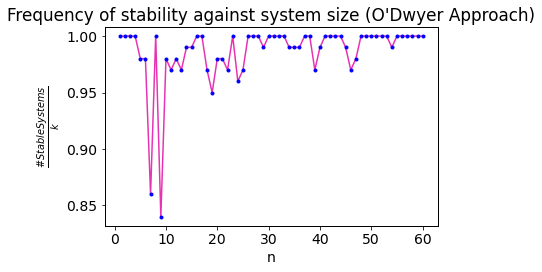

In [12]:
y_data = np.array(percents_stable_Odw)
x_data = np.array(ns_test)

# I forgot how to suppress matplotlib output automatically
plt.plot(x_data,y_data, color=(0.9,0.2,0.7));
plt.plot(x_data,y_data, 'b.');
plt.title('Frequency of stability against system size (O\'Dwyer Approach)');
plt.xlabel('n');
plt.ylabel(r'$\frac{\# Stable Systems}{k}$');
plt.tight_layout();
# looks like logistic growth (decay, really)
plt.show();


# When using AN EVEN HIGHER SAMPLE SIZE (k=1000 vs. k=100 down below), still very chaotic-looking
    # but with dip near n=[8,12]. Hrm...
    # Also, very stable. 

In [87]:
x_data[np.argmin(y_data)] # Least chance of having stable system at this n, probably not an

9

In [ ]:
###########################################################################################
### Instead, consider randomizing the (n,n) P(roduction matrix) and eval'ing its Jacobian only at 
    ### its corresponding steady state.
# Choose k = 5000
# make (k,n,n) array (5000 P matrices)
# make (k,n,1) array (5000 Rstars)
# ""                 (5000 Sstars)

In [13]:
def extract_block_diags(A,block_size):
    '''
    A, square matrix whose (square) block diagonals of shape (block_size,block_size) are to be extracted
    
    This function has zero error handling. Make sure block_size fits the matrix, or whatever.
    '''
    block_diags = np.lib.stride_tricks.sliding_window_view(A,(block_size,block_size))[::block_size,::block_size]
    num_blocks = int(A.shape[0]/block_size)
    block_inds = list(range(num_blocks))
    
    return block_diags[block_inds,block_inds,:,:]

$\vec{R^*} = (C^T)^{-1}\frac{1}{\epsilon}(P^T \vec{1} + \vec{\mu})$)

In [53]:
np.tile(np.random.rand(5),(1,1,1)).shape

(1, 1, 5)

In [83]:
### Resource-Competition Steady State vectors (R_star and S_star)
# Why are Rstars in the range of r_i in [1,100]??? Any way to normalize/nondimensionalize the model?

### According to Butler/O'Dwyer, for any CHOICE of (+) mu and rho, these Fns will produce feasible Steady States

#sP_ex = symPvec(sig=1,n=20,k=10)
# k=10

def R_star_gen(C,P,eps,mu): # P is actually 3-dimensional matrix (k nxn sub-P-matrices)
    r'''
    ..math::
        $\vec{R^*} = (C^T)^{-1}\frac{1}{\epsilon}(P^T \vec{1} + \vec{\mu})$
    
    Generates stack of steady state vectors R_star, where 0th dimension selects the sub-P to which 
    that particular R_star corresponds (i.e. R_star is the equilibrium for the Jacobian formed with that sub-p).
    
    No argument for number of sub-R_stars because that is inferred from 0th dimension of P argument.
    '''
    
    k = P.shape[0]
    n = P.shape[1]
    mu = np.tile(mu,(k,1,1))
    
    #C = np.tile(C,(k,1,1)) # OLD: stack C k times so that it can be dotted with each sub-Ps
                                # np.dot() does not broadcast, I think. Have to manually add 3rd dimension
    #A = np.linalg.inv(np.transpose(C,(0,2,1)))*(1/eps) # split up into A,v for readability
    A = np.linalg.inv(C.T)*(1/eps) # A is just nxn
    v = np.sum(np.transpose(P,(0,2,1)), 2).reshape(k,n,1) + mu #take row sums of P transpose, reshape to add 
    
    # How to pairwise dot an array of 2D matrices with array of column vectors?
    # R_star = np.dot(A,v) # OLD, for stacked C
    
    R_star = np.tensordot(A,v,axes=([1],[1]))
    R_star = R_star.reshape(n,k).T.reshape(k,n,1)
    #np.tensordot(I,b,axes=([1],[1])).reshape(2,3).T.reshape(3,2,1)
    return R_star
#mu = eps * R_star (when specialized C)


$\vec{S^*} = [(R^{*}_{diag})C - P]^{-1} \vec{\rho}$


In [82]:
def S_star_gen(C,P,R_star,rho):
    k = P.shape[0]
    n = P.shape[1]
    
    # How get (k,n,n) array of R_diags, each k a diagonal array with R_star k as its entries?
    # fill main diagonal with flattened R_stars (it will be k*n x k*n), then extract the k nxn block main diagonal matrices
        # HOW EXTRACT BLOCK DIAGONALS IN NUMPY??????
        # Try sliding windows with slicing
    
        # Now, we have extract_block_diags()
    
    R_diag = np.zeros((k*n,k*n))
    np.fill_diagonal(R_diag, R_star.reshape(k*n,))
    # now, R_diag is big array
    R_diag = extract_block_diags(R_diag, n) # get each R_diag in (k,n,n)-shaped array
    
    ### FIX THIS LATER FOR NON-IDENTITY C ################################
    #  RC = np.dot(R_diag, C) # real way would be sth like this
    RC = R_diag
    
    A = np.linalg.inv(RC - P) # pairwise subtract RC and P
    #S_star = np.dot(A, rho)  # in a perfect world, this is the answer
    
    # this time, we have many different sub-A and constant rho
    S_star = np.tensordot(A,rho.reshape(1,n,1),axes=([2],[1])) #.reshape(n,k).T.reshape(k,n,1) # we do not live in a perfect world

    return S_star.reshape(k,n,1)

# rho_ex = np.ones(n).reshape(20,1)
# S_star_ex = S_star_gen(C,sP_ex,R_star_ex,rho_ex)

# S_star_ex.shape

In [48]:
# x = np.random.rand(4*3*2).reshape(4,3,2)
# x
# v = np.arange(2).reshape(1,2,1)
# v

# z = np.tensordot(x,v,axes=([2],[1]))
# z
# z.reshape(4,3,1)


# X = np.identity(9)
# d = extract_block_diags(X,3) # it work
# d

In [18]:
# # Check that R_star_gen works???

# v=(np.sum(np.transpose(sP_ex,(0,2,1)), 2).reshape(k,n,1) + np.tile(mu_ex,(k,1,1))) #10x20x1
# A = np.linalg.inv(np.transpose(np.tile(C,(k,1,1)),(0,2,1)))*(1/eps) # 10x20x20

# X = np.tensordot(A,v,axes=([2],[1]))
# X.shape
# X[0,:,1,:]

# #np.sum(sP_ex[0,:,:].T,1).shape
# #check against manual calculation of first R_star
# #np.all(np.dot(np.linalg.inv(C)/eps,np.sum(sP_ex[0,:,:].T,1).reshape(20,1) + mu_ex) == X[0,:,0,:])

# #np.all(np.dot(np.linalg.inv(C)/eps,np.sum(sP_ex[1,:,:].T,1).reshape(20,1) + mu_ex) == X[1,:,1,:])

In [19]:
### THIS IS (seems to be?) HOW YOU DOT A BUNCH OF MATRICES (only works for single matrix, many vectors)

# b = np.random.rand(6).reshape(3,2,1)
# b

# I = np.identity(2) #2x2
# b.shape # 3x2x1

# out = np.tensordot(I,b,axes=([1],[1]))
# #out
# out = out.reshape(2,3)
# #out
# out = out.T.reshape(3,2,1)
# out.shape
# out



In [99]:
### Now, can generate k P matrices, shape (k,n,n), and the corresponding R and S_stars for Jacobian at equilibrium

### MAKE INTO A FUNCTION

sEVs = np.array([])
aEVs = np.array([])

## Parameters ##

n   = 20      # number of species AND number of resrcs
k = 750       # number of systems to generate
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1      # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES
#mu = np.random.unif(0,1,n) 
mu = (np.ones(n)*0.5).reshape(n,1) # R_star_gen takes 2D mu
#rho = np.random.unif(0,1,n)
rho = (np.ones(n)*0.5).reshape(n,1)


### SEE METHODS FOR mu AND rho

I = np.identity(n)

## Consumption Matrix ##

C = c * I

### Generating Random P-matrices, fixing mu and rho, and eval'ing Jacobian at corresponding equilibrium
    ### Then find dominant eigenvalues.

LD = np.zeros((k, n, n)) # DON'T REEVALUATE EVERY ITERATION

## Production matrices ##
sP = symPvec2(sig, n, k)
aP = asymPvec(sig, n, k)


## Equilibrium Abundances ##
sR_star = R_star_gen(C,sP, eps, mu)
sS_star = S_star_gen(C,sP, sR_star, rho)

aR_star = R_star_gen(C,aP, eps, mu)
aS_star = S_star_gen(C,aP, aR_star, rho)


## Linearized System ##
   ### Jacobian, L, eval'd at steady state
#     [ LA | aLB]
#aL = [---------]
#     [ LC | LD ]

# Community Matrix for Symmetric P
sLA  = -c * sS_star * I
sLB = sP - c * sR_star * I
sLC = eps * c * sS_star * I

# Community Matrix for Asymmetric P
aLA = -c * aS_star * I
aLB = aP - c * aR_star * I
aLC = eps * c * aS_star * I


sL  = np.concatenate((np.concatenate((sLA, sLB),2), np.concatenate((sLC, LD),2)), 1)
# aL  = np.vstack((np.hstack((aLA, aLB)), np.hstack((aLC, LD))))
aL  = np.concatenate((np.concatenate((aLA, aLB),2), np.concatenate((aLC, LD),2)), 1)


## Eigenvalues of Linearized System ##

sEVs = np.append(sEVs, eigvals(sL)) # just turns EVs from an array into a list???
aEVs = np.append(aEVs, eigvals(aL))

In [101]:
# sS_star * I
# wow, broadcasting just works???

In [92]:
# eigvals(sL).shape
# sEVs.shape


## What is going on with the tendency for eigvals ~=~ 0.4???

In [24]:
def rand_eigval_gen(n, k, sig = 1, symmetric=True): # For now, just identity C, ADD AS ARGUMENT LATER
    '''
    Takes same arguments as (a)symPvec(), but performs all of the eigenvalue calcs for each of the k matrices
    
    Needs to be updated to take C as argument. For now, just uses identity matrix for C (perfect specialists).
    Also, mu, rho, and epsilon.
    '''
    
    EVs = np.array([])

    ## Parameters ##

    # n   = 20      # number of species AND number of resrcs
    # k = 750        # number of systems to generate
    eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
    # sig = 25      # std deviation of production rates? Yes, also for abundances?
    c = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES
    #mu = np.random.unif(0,1,n) 
    mu = (np.ones(n)*0.5).reshape(n,1) # R_star_gen takes 2D mu
    #rho = np.random.unif(0,1,n)
    rho = (np.ones(n)*0.5).reshape(n,1)
    ### SEE METHODS FOR mu AND rho


    ## Consumption Matrix ##
    I = np.identity(n)
    C = c * I
    # C = np.identity(n)

    
    # only difference between symmetric=True and otherwise is the call to symPvec2() or asymPvec()
        
    ## Choice of Production matrices ##
    if (symmetric):
        P = symPvec2(sig, n, k) # VECTORIZE the return value/FNs arg to return 'k' such matrices (better than for loop)
    else:
        P = asymPvec(sig, n, k)
    
    ## Linearized System ##
       ### Jacobian, L, eval'd at steady state
    #     [ LA | aLB]
    #aL = [---------]
    #     [ LC | LD ]
    LD = np.zeros((k, n, n))


    ## Equilibrium Abundances ##
    R_star = R_star_gen(C, P, eps, mu)
    S_star = S_star_gen(C, P, R_star, rho)

    # Community Matrix Partitions
    LA  = -c * S_star * I
    LB = P - c * R_star * I
    LC = eps * c * S_star * I


    L  = np.concatenate((np.concatenate((LA, LB),2), np.concatenate((LC, LD),2)), 1)


    # EVs = np.append(EVs, eigvals(L)) # old
    # print(P)
    return eigvals(L)

In [26]:
%%capture # temporary fix to all of the P.shape prints

# small systems (small n) almost Never unstable
 # house of cards funny business
ns_test = list(range(1,41))
percents_stable = []

for nn in ns_test:
    n_test = nn
    k_test=100
    ev_ex = rand_eigval_gen(n_test,k_test,sig = 1, symmetric=False)
    reals = ev_ex.real

    #reals.shape

    # MEANINGLESS, loses the eigvals associations with their respective systems
    pos_real_cts = np.sum(reals>0,-1) # DUE TO COMPLEX CONJUGATES, REALLY ONLY HALF THIS MANY ??? I GUESS, BUT
                            # EVERY EIGVAL HAS COMPLEX CONJUGATE, SO THE FREQUENCY CALC WORKS OUT JUST AS WELL.

    # plot stability as n increases? Past n=~30, few stable systems

    percents_stable.append(len(pos_real_cts[pos_real_cts==0])/k_test) # ratio of stable systems to total systems (k)
    
    
# WHERE IS ALL THE PRINTING COMING FROM????????
 # (k,n,n), so it must be P, but where is P.shape printed?

In [98]:
# asymPvec(1,3,4)

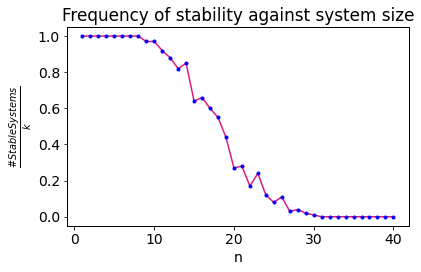

In [100]:
xdata = np.array(ns_test)
ydata = np.array(percents_stable)


# I forgot how to suppress matplotlib output automatically
plt.plot(xdata,ydata, color=(0.85,0.1,0.5));
plt.plot(xdata,ydata, 'b.');

plt.title('Frequency of stability against system size');
plt.xlabel('n');
plt.ylabel(r'$\frac{\# Stable Systems}{k}$');
plt.tight_layout();
# looks like logistic growth (decay, really)
plt.show();
# presence of exponentials makes enough sense given the type of math going on

The above data have a form similar to
$$ F(x) = \frac{e^{rx}}{c+e^{rx}}, $$
with reals $r<0, c>0$.

In [ ]:
# cmap = mpl.cm.get_cmap("magma").copy()
# cmap.set_under(color = 'white') 
# plt.hexbin(sEVs.real, sEVs.imag, bins=None, cmap=cmap, linewidths=0.1) ### bins = 'log' seems unhelpful???

In [124]:
# np.set_printoptions(linewidth=210)

(750, 20, 20)
(750, 20, 20)
(750, 20, 20)
(750, 20, 20)
(750, 20, 20)
(750, 20, 20)
(750, 20, 20)
(750, 20, 20)
(750, 20, 20)
(750, 20, 20)


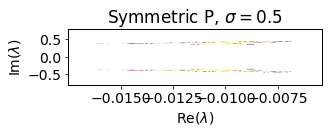

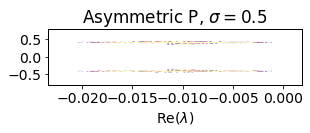

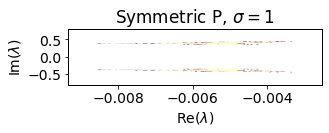

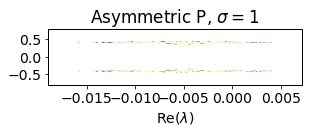

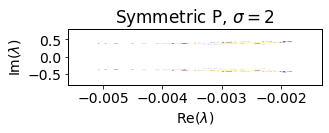

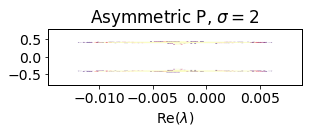

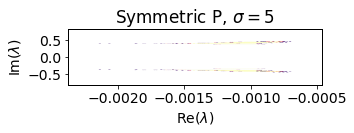

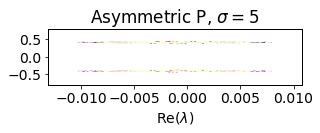

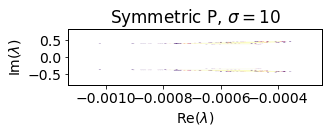

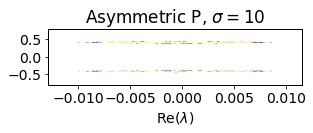

In [36]:


### Plot Eigenvalues of Various Linearized Systems
    ### (Eval'd at the respective steady states for single fixed mu and rho
    
# Loop the code below over a list of sigmas
    # Subplots with left column symmetric, right asymmetric
    # Make list, stability_probs. For each aEVs with different sig, append the
      # ratio of matrices that have any Re(lam)>0 to k.

sigs = [0.5,1,2,5,10]
# sigs = [0.5]
# just have one pair (sEVs,aEVs) at a time for simplicity
    # generate sEVs, aEVs with current sigma
    # plot them
    # append to stability_freq using aEVs

n = 20      # number of species AND number of resrcs
k = 750     # number of systems to generate

stability_freqs = [] # len(sigs)

for j, s in enumerate(sigs):
    
    sEVs = rand_eigval_gen(n, k, sig = s, symmetric=True)
    aEVs = rand_eigval_gen(n, k, sig = s, symmetric=False)
    
    for i, q in enumerate([sEVs, aEVs]): # i index, q current value

        x = q.real
        y = q.imag
        
        
        plt.rcParams["axes.edgecolor"] = "black" 
        plt.rcParams["axes.linewidth"] = 1 

        fig, ax = plt.subplots(figsize = (10, 6))

        #cmap = plt.cm.viridis_r  ### old, gets an error
        cmap = mpl.cm.get_cmap("magma").copy()
        cmap.set_under(color = 'white') 

        plt.axvline(0, c='grey', linestyle='--', linewidth=1, ymin=0.07, ymax=0.93) ### stability threshold (Re = 0)

        font = {'size' : 14}
        plt.rc('font', **font)

        
        plt.subplot(len(sigs),2,(j+i+1));
        plt.hexbin(x, y, bins=None, cmap=cmap, linewidths=0.1) ### bins = 'log' seems unhelpful???

        plt.xlabel(r'Re($\lambda$)')

        plt.clim(10**(-8), 5.0) ### color limits, increase upper for better contrast ???
        ### originally, (10**(-8), 2.0)

        xmin, xmax = plt.xlim()
        nxm = (xmax - xmin) / 10 ### def'n some padding/margins
        plt.xlim((xmin - nxm, xmax + nxm))


        ### Adjusting Re axis tick marks
        if i==0: ### symmetric P
            loc = plticker.MultipleLocator(base=0.01) ### tick marks in increments of 'base'
            ax.xaxis.set_major_locator(loc)
            plt.title(r'Symmetric P, $\sigma={}$'.format(s))
            plt.ylabel(r'Im($\lambda$)')


        if i==1: ### asymmetric P
            loc = plticker.MultipleLocator(base=0.01) ### originally, base = 0.02
            ax.xaxis.set_major_locator(loc)
            plt.title(r'Asymmetric P, $\sigma={}$'.format(s))
            
            cb = plt.colorbar(aspect=40, shrink=0.85, pad=0.07)
            locs = cb.get_ticks()
            tl = locs[-1] * 2 / 25
            cb.set_ticks([tl, locs[-1] - tl])
            cb.set_ticklabels(['Low Density', 'High Density'])


        ymin, ymax = plt.ylim()
        nym = (ymax - ymin) / 3
        plt.ylim((ymin - nym, ymax + nym))

        
        

    
plt.show();

(750, 20, 20)
(750, 20, 20)


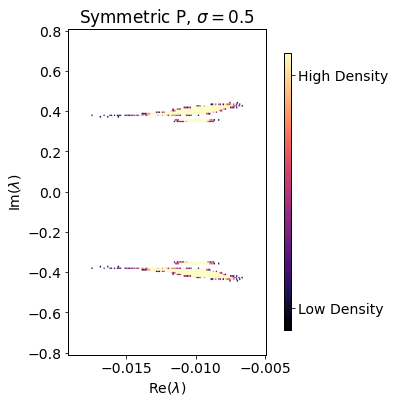

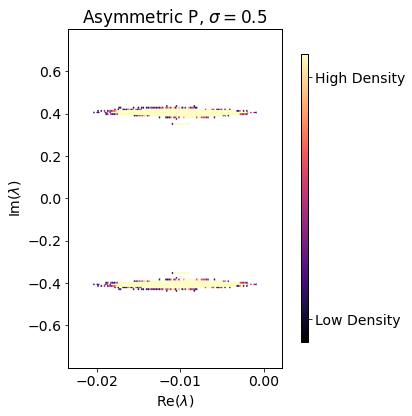

In [20]:
###########################################################
############ Start of Arnoldi Stability Measures ##########
###########################################################

"We showed that in large, complex communities, due to the presence
of species with very different abundances, asymptotic resilience need not even be a good predictor 
of return rates at longer times."

"[...] asymptotic resilience should not be used as a proxy for the short-term recovery."

(pg. 8 "How ecosystems recover[...]")

In [436]:
### Arnoldi Stability Measures
n = 20 #repeated
import scipy as sp # for matrix exponential
from scipy.linalg import expm

In [437]:
# Return Rates
def R_avg(x, t, u):
    '''
    Average rate of return at current displacement 'x' after time 't' since initial perturbation 'u'
    '''
    return -( np.log(np.linalg.norm(x,2)) - np.log(np.linalg.norm(u,2))) / t

In [438]:
### does this still count as 'uniform'???

# Arnoldi Appendix E suggests def'n v with v_i std Gaussian, then normalize to u. Why Gaussian?? 
def u_gen_unif(n):
    '''
    Generate uniformly distributed unit-length  perturbation vector u.
    
    The direction is ostensibly the uniformly distributed value.
    '''
    v = np.random.normal(0,1,n) # so-called 'v' in Arnoldi
    return v/np.linalg.norm(u,2) # does this provide uniformly distributed perturbation direction? They say so.

In [439]:
# Really, according to Arnoldi, perturbations should tend to have greater effect on more abundant species.
# This is pretty subjective, I suppose? Is there empirical justification for this 'tendency'?

In [440]:
# Perturbation covariance matrix, Cov, for uniform perturbation direction
Cov_unif = np.identity(n)/n # for when equilibrium populations not being considered in perturbation distribution

In [441]:
# Choose an example system for testing Arnoldi measures
n_arn = 5
k_arn = 2
sig_arn = 1
eps = 0.25
c = 1
I = np.identity(n_arn)*c
mu_arn = np.ones(n_arn).reshape(n_arn,1) # important, must be column vector
rho_arn = np.ones(n_arn).reshape(n_arn,1)

aP_arn = asymPvec(sig_arn,n_arn,k_arn)
C_arn = np.identity(n_arn)

In [442]:
R_arn = R_star_gen(C_arn, aP_arn, eps, mu_arn)
R_arn
S_arn = S_star_gen(C_arn, aP_arn, R_arn, rho_arn)
S_arn

array([[[16.29021],
        [19.54683],
        [14.74162],
        [23.95382],
        [14.14494]],

       [[14.57408],
        [25.16539],
        [13.63494],
        [26.82732],
        [21.80043]]])

array([[[0.08382],
        [0.06024],
        [0.07832],
        [0.04857],
        [0.09332]],

       [[0.08405],
        [0.05372],
        [0.08647],
        [0.04891],
        [0.05337]]])

In [ ]:
S_star_gen?

In [443]:
LA  = -c * S_arn * I

LB = aP_arn - c * R_arn * I

LC = eps * c * S_arn * I
LD = np.zeros((k_arn,n_arn, n_arn))

L_top = np.concatenate((LA, LB), 2)
L_bot = np.concatenate((LC, LD), 2)
L_arn  = np.concatenate((L_top,L_bot), 1)

In [445]:
R_arn

array([[[16.29021],
        [19.54683],
        [14.74162],
        [23.95382],
        [14.14494]],

       [[14.57408],
        [25.16539],
        [13.63494],
        [26.82732],
        [21.80043]]])

In [444]:
RS_star = np.concatenate((R_arn,S_arn), 1) #(k,2*n,1), an example equilibrium
RS_star1, RS_star2 = RS_star

LAM = np.sum(np.square(RS_star)) #lambda, from Arnoldi Appendix E
Cov_prop = np.zeros((k_arn, 2*n_arn, 2*n_arn))
di_C = np.diag_indices(2*n_arn)
#Below LHS will be (k_arn, n_arn)
Cov_prop[:,di_C[0],di_C[1]] = (np.square(RS_star)/LAM).reshape(k_arn,2*n_arn) ### From Arnoldi Appendix E, Covariance matrix when u_i prop. to N*_i

In [446]:
#Appendix E says the following:
def u_gen_prop(n, Nstar):
    ''' 
    Generate random perturbation 'u' such that u_i proportional to N*_i (population-proportional perturbations).
    '''
    v = np.random.normal(0,1,2*n).T
    D = np.diag(Nstar.reshape(2*n))
    w = np.dot(D,v) # really just pairwise multiplication of Nstar and v
    u = w/np.linalg.norm(w,2)
    return u

# This is a more suitable perturbation model: Expectation of u_i proportional to N*_i

In [447]:
### Median approximations
def disp_median(A,Cov,t): # community matrix A, Covariance matrix Cov, time t
    # displacement = ||x(t)||
    return np.sqrt(np.trace(expm(A*t)*Cov*expm(A.T*t)))

def R_avg_median(A,Cov,t): 
    '''Median of the average return rates'''
    return -(np.log(np.trace(expm(A*t)*Cov*expm(A.T*t))) - np.log(np.trace(Cov))) / (2*t)

In [448]:
disp_med = disp_median(L_arn[0,:,:], Cov_prop[0,:,:], 1)
disp_med

R_avg_med = R_avg_median(L_arn[0,:,:], Cov_prop[0,:,:], 1)
R_avg_med

0.5220173313457657

0.2209791438493261

In [449]:
### Return time 
#c, chosen threshold distance from equilibrium
# T(c) = min(t) such that ||x(t+s)|| <= c for all s>=0 #(does not displace back out of threshold once it reaches return time)

# This will require a numerical solution

In [ ]:
### Numerical solution to a simple system
# Careful of going back and re-running above blocks, reusing a lot of vars here
n_arn = 2
k_arn = 1
sig_arn = 1
eps = 0.25
c = 1
mu_arn = np.ones(n_arn).reshape(n_arn,1) # important, must be column vector
rho_arn = np.ones(n_arn).reshape(n_arn,1)

aP_arn = asymPvec(sig_arn,n_arn,k_arn)
C_arn = np.identity(n_arn) * c

R_arn = R_star_gen(C_arn, aP_arn, eps, mu_arn)
S_arn = S_star_gen(C_arn, aP_arn, R_arn, rho_arn)
RS_arn = np.concatenate((R_arn,S_arn),1)

In [453]:
R_star_gen?

In [454]:
RS_arn

array([[[8.77264],
        [9.83742],
        [0.1372 ],
        [0.1146 ]]])

In [456]:
u_ex = u_gen_prop(n_arn,RS_arn.reshape(4))
np.linalg.norm(u_ex,2) #cool?

1.0

In [457]:
u_ex

array([ 0.95292,  0.30243, -0.00993, -0.01936])

In [458]:
# Just working with one example system, can get rid of "Stacking" for simplicity
aP_arn = aP_arn.reshape(n_arn,n_arn)
RS_arn = RS_arn.reshape(2*n_arn,1)

In [460]:
aP_arn
RS_arn

array([[0.84273, 0.76759],
       [0.35043, 0.69177]])

array([[8.77264],
       [9.83742],
       [0.1372 ],
       [0.1146 ]])

In [468]:
# Start with simple n=2 system for convenience starting out
def ResrcProd(N, t, C, P, mu, rho, eps): # why t? Unused

    R0, R1, S0, S1 = N # Ok, Resources are much more abundant

    dNdt = [rho[0]-R0*(C[0,0]*S0 + C[0,1]*S1) + P[0,0]*S0 + P[0,1]*S1,
            rho[1]-R1*(C[1,0]*S0 + C[1,1]*S1) + P[1,0]*S0 + P[1,1]*S1,
            eps*S0*( (C.T)[0,0]*R0 + (C.T)[0,1]*R1 ) - S0*((P.T)[0,0] + (P.T)[0,1]) - mu[0]*S0,
            eps*S1*( (C.T)[1,0]*R0 + (C.T)[1,1]*R1 ) - S1*((P.T)[1,0] + (P.T)[1,1]) - mu[1]*S1
           ]

    return dNdt

In [465]:
step = ResrcProd(list(RS_arn.reshape(2*n_arn)), 1, C_arn, aP_arn, list(mu_arn.reshape(2)), list(rho_arn.reshape(2)), eps)

In [469]:
step
len(step)

[-4.163336342344337e-17, -1.6653345369377348e-16, 0.0, 1.3877787807814457e-17]

4

In [470]:
from scipy.integrate import odeint
import pandas as pd # once we start numerical solutions, might make sense to switch to dataframes

In [490]:
# Numerical solution for (2,2) system

t = np.linspace(0, 100, 1001) # time to simulate
RS_arn
u_2 = u_gen_prop(n_arn,RS_arn)
np.linalg.norm(u_2,2) # works
u_2 # proportions look good



array([[8.77264],
       [9.83742],
       [0.1372 ],
       [0.1146 ]])

1.0

array([-0.4886 , -0.87249,  0.00556,  0.0027 ])

In [491]:
init_cond = list(u_2+RS_arn.reshape(2*n_arn))
u_2
RS_arn
init_cond

array([-0.4886 , -0.87249,  0.00556,  0.0027 ])

array([[8.77264],
       [9.83742],
       [0.1372 ],
       [0.1146 ]])

[8.284043211157462, 8.964937959831172, 0.1427597960253595, 0.11730065056790306]

In [492]:
sol = odeint(ResrcProd, init_cond, t, args=(C_arn, aP_arn.reshape(2,2), list(mu_arn.reshape(2)), list(rho_arn.reshape(2)), eps))

In [493]:
sol.shape
sol = np.array(sol)

(1001, 4)

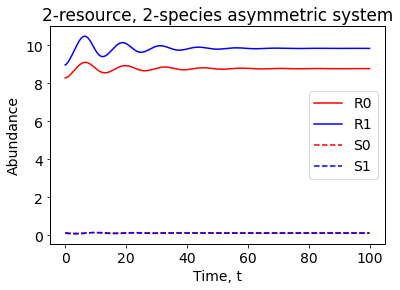

In [494]:
plt.plot(t, sol[:,0], 'r', label = 'R0');
plt.plot(t, sol[:,1],'b', label = 'R1');
plt.plot(t, sol[:,2],'r--', label = 'S0');
plt.plot(t, sol[:,3],'b--', label = 'S1');
plt.legend();

plt.title('2-resource, 2-species asymmetric system')
plt.xlabel('Time, t');
plt.ylabel('Abundance');

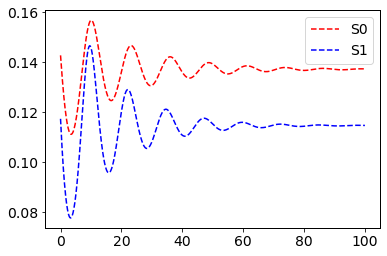

In [495]:
# giving the little guys a chance
plt.plot(t, sol[:,2],'r--', label = 'S0');
plt.plot(t, sol[:,3],'b--', label = 'S1');
plt.legend();


In [ ]:
 ### NEXT STEPS FOR ARNOLDI TOOLS:
    ### Pick a threshold for the oscillations such that settles in ...

In [476]:
RS_arn
sol

array([[8.77264],
       [9.83742],
       [0.1372 ],
       [0.1146 ]])

array([[ 7.88751,  9.37214,  0.14279,  0.11835],
       [ 7.89699,  9.37493,  0.13968,  0.11699],
       [ 7.90837,  9.37876,  0.13667,  0.11565],
       [ 7.92157,  9.38358,  0.13377,  0.11433],
       [ 7.9365 ,  9.38937,  0.13098,  0.11305],
       [ 7.95307,  9.39609,  0.1283 ,  0.1118 ],
       [ 7.97119,  9.40372,  0.12572,  0.11059],
       [ 7.99078,  9.41221,  0.12326,  0.1094 ],
       [ 8.01175,  9.42153,  0.1209 ,  0.10826],
       [ 8.03402,  9.43165,  0.11866,  0.10715],
       [ 8.05751,  9.44253,  0.11652,  0.10609],
       [ 8.08214,  9.45414,  0.11449,  0.10506],
       [ 8.10784,  9.46643,  0.11257,  0.10407],
       [ 8.13453,  9.47937,  0.11075,  0.10313],
       [ 8.16214,  9.49293,  0.10903,  0.10223],
       [ 8.19059,  9.50706,  0.10742,  0.10137],
       [ 8.21981,  9.52173,  0.10591,  0.10055],
       [ 8.24974,  9.53689,  0.10449,  0.09978],
       [ 8.28031,  9.55252,  0.10318,  0.09905],
       [ 8.31145,  9.56857,  0.10195,  0.09837],
       [ 8.3431 ,  9

In [477]:
RS_arn

array([[8.77264],
       [9.83742],
       [0.1372 ],
       [0.1146 ]])

In [418]:
sol_xs = np.tile(RS_arn.reshape(4), (len(t), 1)) - sol # running difference between each state variable and its respective equilibrium
sol_xs

array([[ 6.80554e+00,  1.80939e+01,  1.45924e-01,  6.91107e-02],
       [ 6.69233e+00,  1.79805e+01,  5.99962e-02, -1.16109e-02],
       [ 6.56440e+00,  1.78498e+01, -1.30474e-02, -6.33053e-02],
       [ 6.42837e+00,  1.77091e+01, -7.56427e-02, -9.67523e-02],
       [ 6.28896e+00,  1.75628e+01, -1.29777e-01, -1.18714e-01],
       [ 6.14953e+00,  1.74138e+01, -1.77051e-01, -1.33430e-01],
       [ 6.01244e+00,  1.72640e+01, -2.18750e-01, -1.43564e-01],
       [ 5.87937e+00,  1.71143e+01, -2.55895e-01, -1.50790e-01],
       [ 5.75148e+00,  1.69656e+01, -2.89300e-01, -1.56166e-01],
       [ 5.62956e+00,  1.68184e+01, -3.19610e-01, -1.60361e-01],
       [ 5.51410e+00,  1.66729e+01, -3.47336e-01, -1.63800e-01],
       [ 5.40540e+00,  1.65294e+01, -3.72885e-01, -1.66753e-01],
       [ 5.30360e+00,  1.63881e+01, -3.96577e-01, -1.69393e-01],
       [ 5.20871e+00,  1.62489e+01, -4.18664e-01, -1.71830e-01],
       [ 5.12067e+00,  1.61121e+01, -4.39348e-01, -1.74134e-01],
       [ 5.03933e+00,  1.

In [406]:
disps = np.lin

NameError: name 'disps' is not defined

In [402]:
# plt.plot(t, sol[:,0], 'r', sol[:,1],'b', sol[:,2],'r--', sol[:,3],'b--');

In [ ]:
######################################
######## Back to O'Dwyer Plots #######
######################################

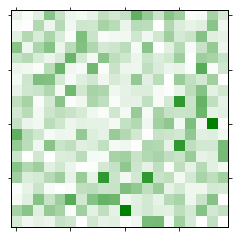

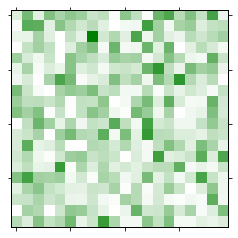

In [132]:
### Plot Grid Representing Production Matrix P ###

for i, M in enumerate([sP, aP]):
    
    c_map = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                               ['white', 'green'],
                                               256)
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1

    fig, ax = plt.subplots()

    img = plt.imshow(M, interpolation='nearest',
                    cmap=c_map)

    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    plt.tick_params(axis = 'both',          
                    which = 'both',      
                    bottom = 'off',      
                    top = 'off',         
                    labelbottom = 'off',
                    left = 'off',
                    right = 'off')

    ax.grid(False)
plt.show();

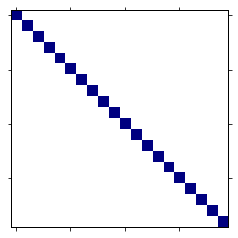

In [133]:
### Plot grid representing consumption C ###

C = c*I

for M in [C]:
    c_map = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                               ['white', 'navy'],
                                               256)
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1

    fig, ax = plt.subplots()

    img = plt.imshow(M, interpolation='nearest',
                        cmap=c_map)


    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    plt.tick_params(axis='both',          
                    which='both',      
                    bottom='off',      
                    top='off',         
                    labelbottom='off',
                    left='off',
                    right='off')

    ax.grid(False)


In [ ]:
### Diversity Indices

#def alpha_???(N): # population vector N
    